In [8]:
# Standard librairy
import os
from pathlib import Path
from tqdm import tqdm

# Librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ML librairies
import torch
import torch.nn as nn

In [9]:
from transformers import (
    PatchTSTConfig,
    PatchTSTForPrediction,
    PatchTSTForClassification,
    PatchTSTForRegression,
    PatchTSTForPretraining
)

In [10]:
model_name = "namctin/patchtst_etth1_regression"
token = os.getenv('HUGGING_FACE_HUB_TOKEN')


patch_tst = PatchTSTForRegression.from_pretrained(model_name, use_auth_token=token)
print(patch_tst)
print("----------------")
print(patch_tst.model.encoder)
print("----------------")
print(patch_tst.head)

PatchTSTForRegression(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [12]:
class CustomDecoder(nn.Module):
    def __init__(self, encoder_dim, prediction_length, num_features, hidden_dim=256, num_layers=2):
        super().__init__()
        
        self.prediction_length = prediction_length
        self.num_features = num_features
        
        self.layers = nn.ModuleList()
        # First layer
        self.layers.append(nn.Linear(encoder_dim, hidden_dim))
        self.layers.append(nn.GELU())
        self.layers.append(nn.Dropout(0.2))
        # Other layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.GELU())
            self.layers.append(nn.Dropout(0.2))
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, prediction_length)
        
    def forward(self, x):
        # x shape: (batch_size, num_features, num_patches, encoder_dim)
        # Aggregation of all patches
        # x = x.mean(dim=2)           # (batch_size, num_features, encoder_dim)
        # Gather and flatten the num_patches and encoder dimension
        x = x.view(x.size(0), x.size(1), -1)  # (batch_size, num_features, num_patches * encoder_dim)
        for layer in self.layers:
            x = layer(x)
        output = self.output_layer(x)  # (batch_size, prediction_length * num_features)
        output = output.view(-1, self.prediction_length, self.num_features) # (batch_size, prediction_length, num_features)
        return output

In [31]:
class NewModelWithCustomDecoder(nn.Module):
    def __init__(self, patchtst_model, prediction_length, num_features, decoder_hidden_dim=256, num_layers=2):
        super().__init__()
        self.patchifier = patchtst_model.model.patchifier
        self.encoder = patchtst_model.model.encoder
        for param in self.patchifier.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        self.decoder = CustomDecoder(
            encoder_dim=128*42,  # d_model of encoder
            prediction_length=prediction_length,
            num_features=num_features,
            hidden_dim=decoder_hidden_dim,
            num_layers=num_layers
        )
        
    def forward(self, x):#, observed_indicator=None):
        # if observed_indicator is None:
        #     observed_indicator = torch.ones_like(x[..., :1])
        with torch.no_grad():
            x = self.patchifier(x)
            encoded = self.encoder(x)["last_hidden_state"]
        output = self.decoder(encoded)
        return output

In [32]:
# New model with custom decoder
patchtst_model = PatchTSTForRegression.from_pretrained(
    "namctin/patchtst_etth1_regression", 
    use_auth_token=os.getenv('HUGGING_FACE_HUB_TOKEN')
    )
new_model = NewModelWithCustomDecoder(
    patchtst_model=patchtst_model,
    prediction_length=96,
    num_features=6,
    decoder_hidden_dim=256,
    num_layers=3
)
new_model

NewModelWithCustomDecoder(
  (patchifier): PatchTSTPatchify()
  (encoder): PatchTSTEncoder(
    (embedder): PatchTSTEmbedding(
      (input_embedding): Linear(in_features=12, out_features=128, bias=True)
    )
    (positional_encoder): PatchTSTPositionalEncoding(
      (positional_dropout): Identity()
    )
    (layers): ModuleList(
      (0-2): 3 x PatchTSTEncoderLayer(
        (self_attn): PatchTSTAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (dropout_path1): Identity()
        (norm_sublayer1): PatchTSTBatchNorm(
          (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias

In [33]:
optimizer = torch.optim.Adam(new_model.decoder.parameters(), lr=5e-3)
criterion = nn.MSELoss()

In [49]:
def create_wave(kapa, beta, t, A=1, m=1):
    #return A * np.exp(-beta * t / (2 * m)) * np.cos(np.sqrt(kapa - (beta / (2 * m))**2) * t)
    return A * np.cos(kapa * t)
Create_wave = np.vectorize(create_wave)
kapa = np.linspace(8.0, 10.0, 6)[np.newaxis, :]
beta = np.linspace(0.05, 0.5, 6)[np.newaxis, :]

time_past = np.linspace(0, 50000, 5120096)[:, np.newaxis]
wave_past = Create_wave(kapa, beta, time_past)

print(wave_past.shape)

(5120096, 6)


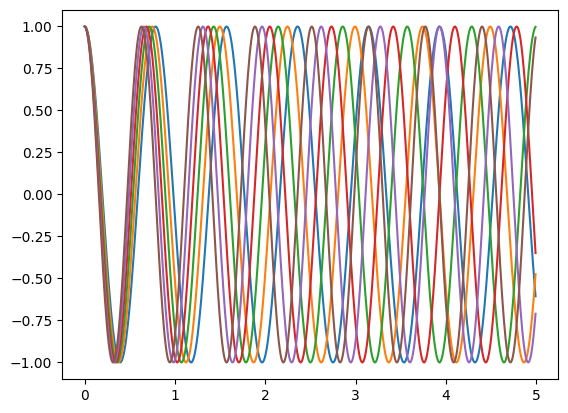

In [50]:
plt.plot(time_past[:512], wave_past[:512])
plt.show()

In [51]:
# Creation of dataset and dataloader

class WaveDataset(torch.utils.data.Dataset):
    def __init__(self, wave_data, past_length=512, future_length=96, stride=512):
        self.wave_data = wave_data
        self.past_length = past_length
        self.future_length = future_length
        self.stride = stride
    
        self.num_samples = (len(wave_data) - past_length - future_length) // stride

    def __len__(self):
        return (len(self.wave_data) - self.past_length - self.future_length) // self.stride

    def __getitem__(self, idx):
        start_idx = idx * self.stride
        past = self.wave_data[start_idx:start_idx + self.past_length, :]

        future_start = start_idx + self.past_length
        future = self.wave_data[future_start:future_start + self.future_length, :]
        
        return {"past_values": past, "future_values": future}

dataset = WaveDataset(wave_past, past_length=512, future_length=96, stride=512)

print(f"Longueur du dataset: {len(dataset)}")
print(f"Taille des données d'entrée: {len(wave_past)}")
print(f"Nombre d'échantillons valides: {len(dataset)}")

if len(dataset) > 0:
    sample = dataset[0]
    print(f"Exemple d'élément du dataset: {sample['past_values'].shape}, {sample['future_values'].shape}")
else:
    print("Le dataset est vide - vérifiez la longueur de vos données")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True, drop_last=True)

for batch in dataloader:
    print(f"\nBatch past values shape: {batch['past_values'].shape}")
    print(f"Batch future values shape: {batch['future_values'].shape}")
    print(batch.keys())
    break

Longueur du dataset: 9999
Taille des données d'entrée: 5120096
Nombre d'échantillons valides: 9999
Exemple d'élément du dataset: (512, 6), (96, 6)

Batch past values shape: torch.Size([512, 512, 6])
Batch future values shape: torch.Size([512, 96, 6])
dict_keys(['past_values', 'future_values'])


In [52]:
# Print the parameters of the new model
new_model.to(device)
print(new_model)

# Print trainable parameters
trainable_params = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in new_model.parameters())
print(f"Trainable parameters: {trainable_params} / {total_params} ({100*trainable_params/total_params:.2f}%)")
print("Encoder parameter number: ", sum(p.numel() for p in new_model.encoder.parameters()))
print("Decoder parameter number: ", sum(p.numel() for p in new_model.decoder.parameters()))
print("Total parameter number: ", sum(p.numel() for p in new_model.parameters()))

NewModelWithCustomDecoder(
  (patchifier): PatchTSTPatchify()
  (encoder): PatchTSTEncoder(
    (embedder): PatchTSTEmbedding(
      (input_embedding): Linear(in_features=12, out_features=128, bias=True)
    )
    (positional_encoder): PatchTSTPositionalEncoding(
      (positional_dropout): Identity()
    )
    (layers): ModuleList(
      (0-2): 3 x PatchTSTEncoderLayer(
        (self_attn): PatchTSTAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (dropout_path1): Identity()
        (norm_sublayer1): PatchTSTBatchNorm(
          (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias

In [53]:
history = {"train_loss_epoch": [], "train_loss_step": []}
N_epoch = 100

# patch_tst.to(device)
new_model.to(device)
for epoch in range(N_epoch):
    loss_total = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{N_epoch}", leave=False):
        past_values = batch['past_values'].float().to(device)
        future_values = batch['future_values'].float().to(device)

        optimizer.zero_grad()
        predictions = new_model(past_values) * past_values.std(dim=1, keepdim=True) + past_values.mean(dim=1, keepdim=True)

        loss = criterion(predictions, future_values)
        loss.backward()
        optimizer.step()
        history["train_loss_step"].append(loss.item())
        loss_total += loss.item()

    history["train_loss_epoch"].append(loss_total / len(dataloader))
    print(f"Epoch {epoch+1}/{N_epoch}, Loss: {loss_total / len(dataloader):.6f}")

Epoch 1/100, Loss: 0.474118


Epoch 2/100, Loss: 0.431101


Epoch 3/100, Loss: 0.424003


Epoch 4/100, Loss: 0.422496


Epoch 5/100, Loss: 0.421952


Epoch 6/100, Loss: 0.421759


Epoch 7/100, Loss: 0.421342


Epoch 8/100, Loss: 0.421337


Epoch 9/100, Loss: 0.421316


Epoch 10/100, Loss: 0.421189


Epoch 11/100, Loss: 0.421283


Epoch 12/100, Loss: 0.421072


Epoch 13/100, Loss: 0.421185


Epoch 14/100, Loss: 0.420946


Epoch 15/100, Loss: 0.420997


Epoch 16/100, Loss: 0.421052


Epoch 17/100, Loss: 0.420789


Epoch 18/100, Loss: 0.420803


Epoch 19/100, Loss: 0.420817


Epoch 20/100, Loss: 0.420993


Epoch 21/100, Loss: 0.420783


Epoch 22/100, Loss: 0.420835


Epoch 23/100, Loss: 0.420747


Epoch 24/100, Loss: 0.420891


Epoch 25/100, Loss: 0.420762


Epoch 26/100, Loss: 0.420784


Epoch 27/100, Loss: 0.420769


Epoch 28/100, Loss: 0.420724


Epoch 29/100, Loss: 0.420739


Epoch 30/100, Loss: 0.420716


KeyboardInterrupt: 

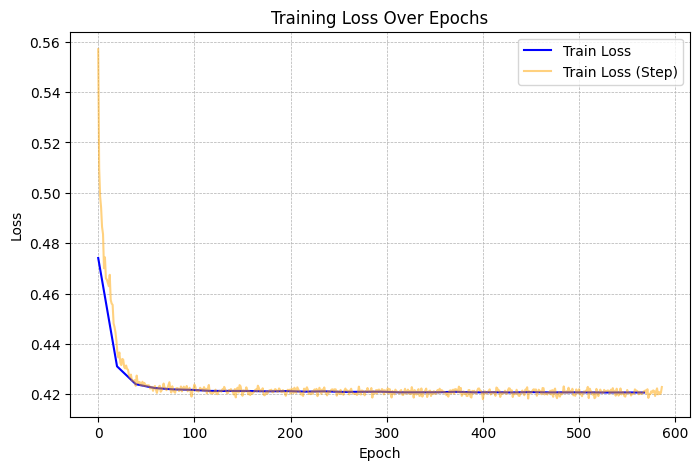

In [54]:
fig = plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(history["train_loss_epoch"]))*len(history["train_loss_step"])/len(history["train_loss_epoch"]), history["train_loss_epoch"], label='Train Loss', color='blue')
plt.plot(np.arange(len(history["train_loss_step"])), history["train_loss_step"], label='Train Loss (Step)', color='orange', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [55]:
# Timeserie d'un pendule amorti
def create_wave(kapa, beta, t, A=1, m=1):
    #return A * np.exp(-beta * t / (2 * m)) * np.cos(np.sqrt(kapa - (beta / (2 * m))**2) * t)
    return A * np.cos(kapa * t)
Create_wave = np.vectorize(create_wave)

kapa = np.linspace(1.0, 10.0, 6)[np.newaxis, :]
beta = np.linspace(0.05, 0.5, 6)[np.newaxis, :]

time_past = np.linspace(0, 10, 512)[:, np.newaxis]
wave_past = Create_wave(kapa, beta, time_past)
wave_past = torch.tensor(wave_past, dtype=torch.float32).unsqueeze(0)

time_future = np.linspace(10, 12, 96)[:, np.newaxis]
wave_future = Create_wave(kapa, beta, time_future)
wave_future = torch.tensor(wave_future, dtype=torch.float32).unsqueeze(0)

print(wave_past.shape)
print(wave_future.shape)

batch = {
    "past_values": wave_past,
    "future_values": wave_future
}
batch

torch.Size([1, 512, 6])
torch.Size([1, 96, 6])


{'past_values': tensor([[[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
          [ 0.9998,  0.9985,  0.9960,  0.9922,  0.9872,  0.9809],
          [ 0.9992,  0.9940,  0.9838,  0.9688,  0.9489,  0.9244],
          ...,
          [-0.8597, -0.9272, -0.2637,  0.6077,  1.0000,  0.6039],
          [-0.8496, -0.9463, -0.3494,  0.5037,  0.9875,  0.7474],
          [-0.8391, -0.9626, -0.4322,  0.3919,  0.9497,  0.8623]]]),
 'future_values': tensor([[[-0.8391, -0.9626, -0.4322,  0.3919,  0.9497,  0.8623],
          [-0.8274, -0.9769, -0.5173,  0.2647,  0.8818,  0.9491],
          [-0.8154, -0.9878, -0.5977,  0.1328,  0.7876,  0.9940],
          [-0.8031, -0.9953, -0.6724, -0.0016,  0.6701,  0.9949],
          [-0.7903, -0.9993, -0.7408, -0.1359,  0.5326,  0.9520],
          [-0.7773, -0.9998, -0.8023, -0.2677,  0.3793,  0.8670],
          [-0.7639, -0.9969, -0.8562, -0.3947,  0.2147,  0.7437],
          [-0.7501, -0.9905, -0.9022, -0.5146,  0.0438,  0.5876],
          [-0.7360, -0.980

In [56]:
new_model.eval()
with torch.no_grad():
    past_values, future_values = batch["past_values"].to(device).float(), batch["future_values"].to(device).float()

    outputs_inference = new_model(past_values)
    predictions = outputs_inference * past_values.std(dim=1, keepdim=True) + past_values.mean(dim=1, keepdim=True)

    past_values_np = past_values.cpu().numpy()
    predictions_np = predictions.cpu().numpy()
    
    if "future_values" in batch:
        future_values_np = future_values.cpu().numpy()

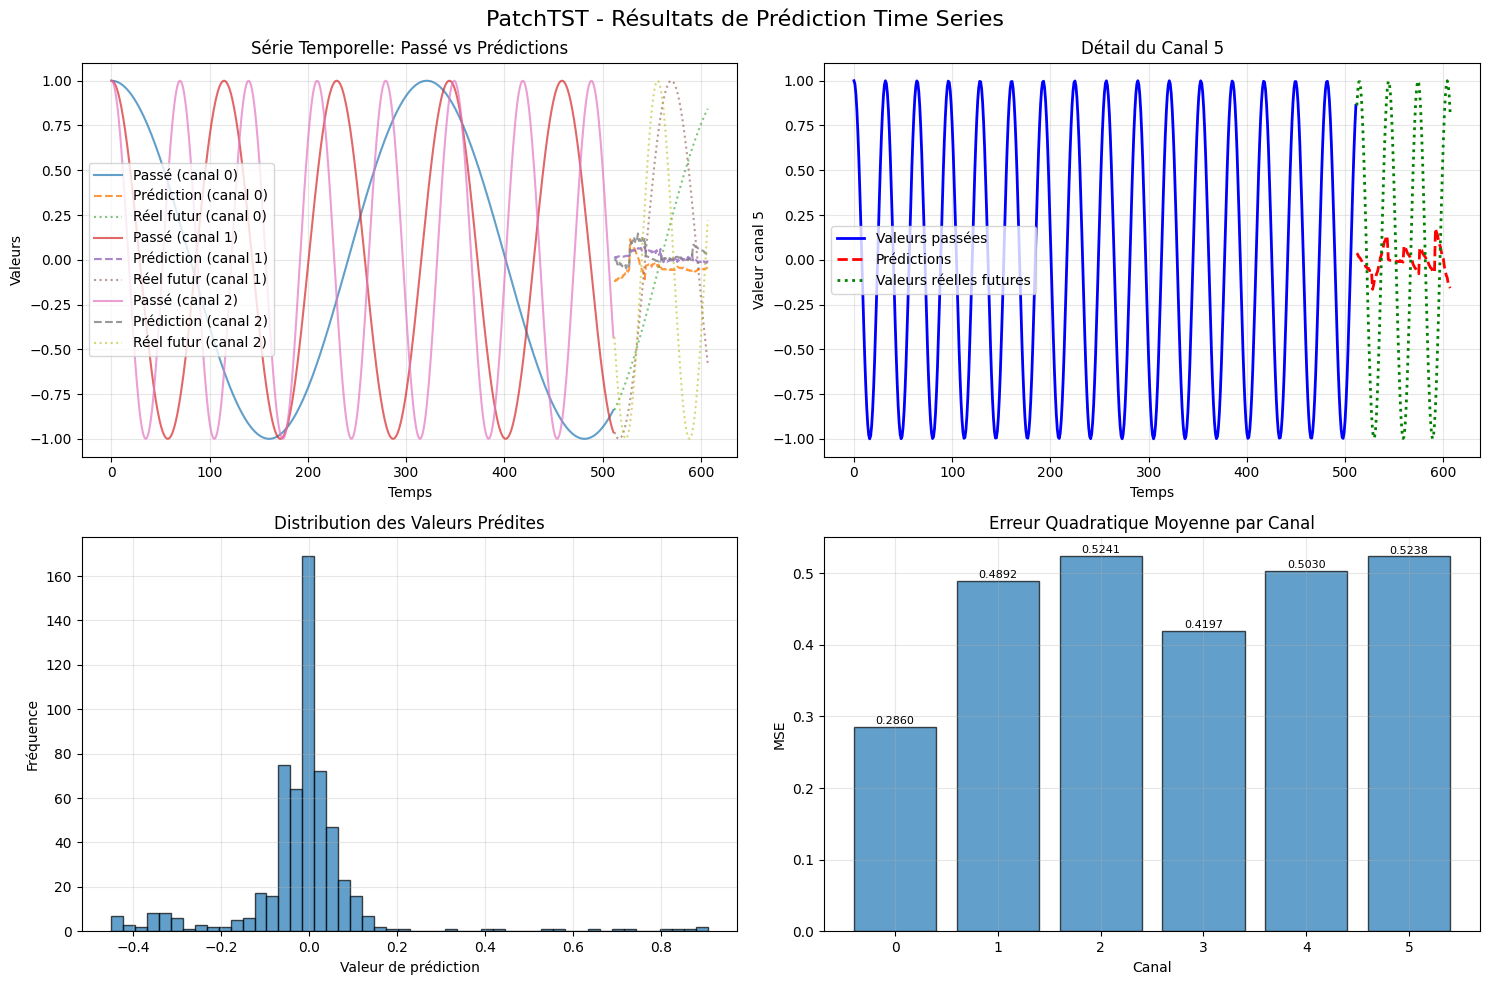

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('PatchTST - Résultats de Prédiction Time Series', fontsize=16)

# Graphique 1: Série temporelle complète avec prédictions
ax1 = axes[0, 0]
time_axis_past = np.arange(past_values_np.shape[1])
time_axis_future = np.arange(past_values_np.shape[1], 
                            past_values_np.shape[1] + predictions_np.shape[1])

# Affichage de quelques canaux sélectionnés
channels_to_plot = min(3, past_values_np.shape[2])  # Maximum 3 canaux

for i in range(channels_to_plot):
    ax1.plot(time_axis_past, past_values_np[0, :, i], 
             label=f'Passé (canal {i})', alpha=0.7)
    ax1.plot(time_axis_future, predictions_np[0, :, i], 
             '--', label=f'Prédiction (canal {i})', alpha=0.8)
    
    if "future_values" in batch:
        ax1.plot(time_axis_future, future_values_np[0, :, i], 
                 ':', label=f'Réel futur (canal {i})', alpha=0.6)

ax1.set_xlabel('Temps')
ax1.set_ylabel('Valeurs')
ax1.set_title('Série Temporelle: Passé vs Prédictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Détail d'un canal spécifique
ax2 = axes[0, 1]
channel_to_detail = 5  # Premier canal

ax2.plot(time_axis_past, past_values_np[0, :, channel_to_detail], 
         'b-', label='Valeurs passées', linewidth=2)
ax2.plot(time_axis_future, predictions_np[0, :, channel_to_detail], 
         'r--', label='Prédictions', linewidth=2)

if "future_values" in batch:
    ax2.plot(time_axis_future, future_values_np[0, :, channel_to_detail], 
             'g:', label='Valeurs réelles futures', linewidth=2)

ax2.set_xlabel('Temps')
ax2.set_ylabel(f'Valeur canal {channel_to_detail}')
ax2.set_title(f'Détail du Canal {channel_to_detail}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Graphique 3: Distribution des prédictions
ax3 = axes[1, 0]
all_predictions = predictions_np.flatten()
ax3.hist(all_predictions, bins=50, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Valeur de prédiction')
ax3.set_ylabel('Fréquence')
ax3.set_title('Distribution des Valeurs Prédites')
ax3.grid(True, alpha=0.3)

# Graphique 4: Métriques par canal (si valeurs futures disponibles)
ax4 = axes[1, 1]
if "future_values" in batch:
    mse_by_channel = np.mean((predictions_np - future_values_np) ** 2, axis=1)[0]
    channels = range(len(mse_by_channel))
    
    bars = ax4.bar(channels, mse_by_channel, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('MSE')
    ax4.set_title('Erreur Quadratique Moyenne par Canal')
    ax4.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, mse_by_channel):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontsize=8)
else:
    # Graphique alternatif: amplitudes par canal
    amplitudes = np.ptp(predictions_np, axis=1)[0]  # Peak-to-peak
    channels = range(len(amplitudes))
    
    bars = ax4.bar(channels, amplitudes, alpha=0.7, edgecolor='black', color='orange')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('Amplitude (max-min)')
    ax4.set_title('Amplitude des Prédictions par Canal')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()